# Задание
* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Попробовать найти закономерности в данных при помощи графиков разного вида

In [9]:
import requests
import pandas as pd
import pathlib

## Получаем cписок из limit_ объектов

In [10]:
offset_ = 1
limit_ = 500
url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
res = requests.get(url)
objects_data = res.json()
objects_list = objects_data.get('data').get('list')

In [11]:
## Получаем нормализованные данные, cохраняем в pandas dataframe обогащеннные данные

In [23]:
import json
from io import StringIO

# json_string = json.dumps(objects_list)
# with open('my_json_data.json', 'w') as file:
#    json.dump(json_string, file)
#df = pd.read_json(StringIO(json.dumps(objects_list)))

url_pattern = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{}'

df1 = pd.json_normalize(objects_list)
jsonlist = []
for elem in objects_list:
    objId = elem.get('objId')
    object_info_url = url_pattern.format(objId)
    json = requests.get(object_info_url).json().get('data')
    jsonlist.append(json)
df2 = pd.json_normalize(jsonlist)
cols_to_use = df2.columns.difference(df1.columns)
df =  pd.concat([df1, df2[cols_to_use]], axis=1)
#del result["id"] #id=objId
#del result["objectTransportInfo"]
df.to_excel("out_excel.xlsx", sheet_name='sheet1')

## Гистограмма по числу жилых и нежилых строений

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_excel('out_excel.xlsx', engine='openpyxl')

df2 = df['buildType'].map(lambda x: 1 if x == 'Жилое' else 0)
hist_info2 = plt.hist(df2, bins = 2, edgecolor='red')
df

## Гистограмма по числу квартир в жилых домах

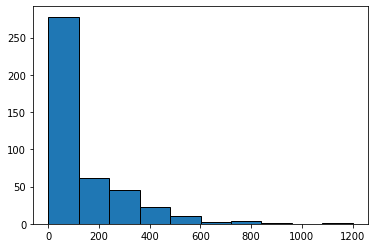

In [415]:
df1 = df['objElemLivingCnt'][df['buildType']=='Жилое']
hist_info = plt.hist(df1, bins=10, edgecolor='black')

## Районы с наиболее активным строительством

In [ ]:
#plt.figure(figsize=(10, 5))
#plt.scatter(x=df['longitude'], y=df['latitude'], s=5, marker='o')
#plt.show()
#max(df['longitude'])

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(p) for p in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 10)), marker='*', color='red', markersize=10);

## Диаграмма распределения средней стоимости в зависимости от материала и типа строения

In [ ]:
sns.catplot(
    x='wallMaterialShortDesc',
    y='objPriceAvg',
    hue='objLkClassDesc',
    kind='bar',
    estimator = np.median,
    height=4,
    aspect=2,
    data = df)
plt.title('Столбиковая диаграмма', size=20, color='b', weight='bold');


In [ ]:
import plotly.express as px

df3 = df[['rpdRegionCd','buildType']][df['buildType'] == 'Жилое']
fig = px.pie(df3, values='rpdRegionCd', names='rpdRegionCd', title='Распределение строящихся жилых объектов по регионам')

fig.show()